# Simple example

This section will present the main functionality of the `pymcdm_reidentify` library. In this example, we will use artificial data in the form of a decision matrix and other parameters needed for the models.

Since the `pymcdm_reidentify` library is based on `pymcdm` and `mealpy`, these modules will also be utilized in this example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mealpy.swarm_based.PSO import OriginalPSO

from pymcdm.methods import TOPSIS, SPOTIS, COMET
from pymcdm.methods.comet_tools import MethodExpert, get_local_weights
from pymcdm.visuals import comet_contourf, ranking_scatter

from pymcdm_reidentify.methods import SESP, SITCOM, SITW, SITWLocal, STFN, STRFN
from pymcdm_reidentify.methods.comet_tools import MLExpert
from pymcdm_reidentify.visuals import model_contourf, fitness_plot, tfn_plot, trfn_plot, weights_diff_plot
from pymcdm_reidentify.normalizations import FuzzyNormalization

Creation of an artificial decision matrix with 2 criteria and 1000 alternatives.

In [2]:
matrix = np.random.random((1000, 2))

Definition of expert parameters such as weights, criteria types or expected solution point. All according to the logic of the MCDA/MCDM methods presented [here](https://pymcdm.readthedocs.io/en/master/example/Example.html).

In [3]:
types = np.array([-1, 1])
weights = np.array([0.5, 0.5])
esp = np.array([0.5, 0.5])

Below is a 3D visualisation of the unknown expert model. The SPOTIS method was used to create it.

In [4]:
bounds = np.array([[0, 1], [0, 1]])
spotis = SPOTIS(bounds, esp)

In [5]:
preference_unknown_model = spotis(matrix, weights, types)
rank_unknown_model = spotis.rank(preference_unknown_model)

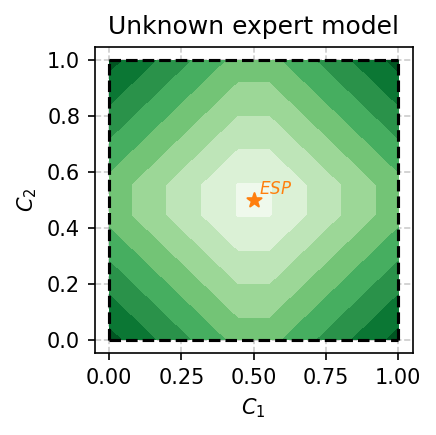

In [6]:
fig, ax = plt.subplots(figsize=(3, 3),  dpi=150, tight_layout=True)
model_contourf(spotis, bounds, esp=esp, model_kwargs={'weights': weights, 'types': types})
ax.set_title('Unknown expert model')
plt.show()

## Using re-identification methods to develop a similar expert model

### Stochastic Expected Solution Point (SESP)

The first method that will be presented to re-identify the expert model will be the SESP method. It is characterised by the search for an Expected Solution Point, with which a decision model can be identified.

A stochastic optimization method will be used to search for the Expected Solution Point in this case. The implementation will use the MealPy library, which is based on various stochastic methods, and it is this library that will be used in this example.

For this method, it is necessary to have the information related to the learning of such a model, i.e. the alternatives, weights, types and boundaries of the decision model.In this case, the data from the previous model will be used.

In this example:
- explicit data are: alternatives, rank of alternatives, weights, types and boundaries of the decision model
- implicit data are: esp

In [7]:
# Selection of a stochastic optimization method with its hyper parameters.
stoch = OriginalPSO(epoch=1000, pop_size=100)

# Creation of a SEPS model object
sesp = SESP(stoch.solve, SPOTIS(bounds), types)

In [8]:
# Learning the model. The log_to argument was used to avoid search messages per ESP epoch.
sesp.fit(matrix, rank_unknown_model, log_to=None)

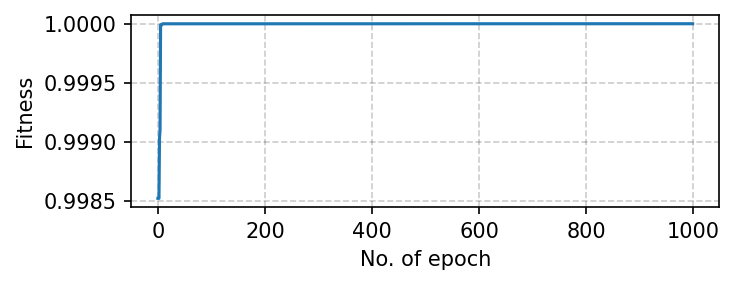

In [9]:
# Visualisation of the learning process 
fig, ax = plt.subplots(figsize=(5, 2), dpi=150, tight_layout=True)
fitness_plot(stoch, ax=ax)
plt.show()

In [10]:
# Reference ESP value
print(esp)
# Obtained ESP value
print(sesp())
# Mean absolute error
print(np.sum(np.abs(esp - sesp())))

[0.5 0.5]
[0.49999946 0.49999947]
1.0659384697131458e-06


### Stochastic IdenTification Of Models (SITCOM)

The second method related to the re-identification of decision models is SITCOM. This method is mainly based on the assumptions of the COMET approach, where, using stochastic optimization, the preference values of characteristic objects are searched with which a similar COMET model can be reconstructed. 

In this example:
- explicit data are: alternatives, rank of alternatives, characteristics values
- implicit data are: preference of characteristics objects

In [11]:
# Creation of characteristic values
cvalues = np.vstack((
    [0, 0],
    [0.5, 0.5],
    [1, 1]
)).T

In [12]:
# Selection of a stochastic optimization method with its hyper parameters.
stoch = OriginalPSO(epoch=1000, pop_size=100)

# Creation of a SITCOM model object
sitcom = SITCOM(stoch.solve, cvalues)

In [13]:
# Learning the model. The log_to argument was used to avoid search messages per preference of characteristics objects epoch.
sitcom.fit(matrix, rank_unknown_model, log_to=None)

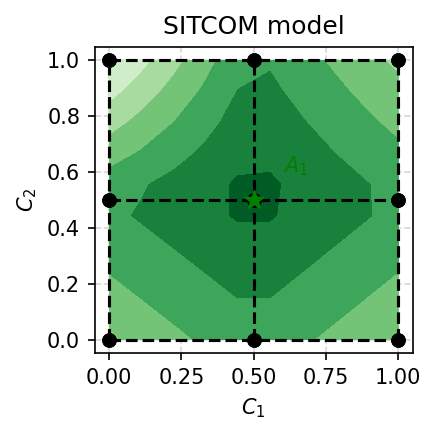

In [14]:
# Visualization of the resulting SITCOM model
fig, ax = plt.subplots(figsize=(3, 3),  dpi=150, tight_layout=True)
comet_contourf(sitcom.model, np.array([[0.5, 0.5]]), 10)
ax.set_title('SITCOM model')
plt.show()

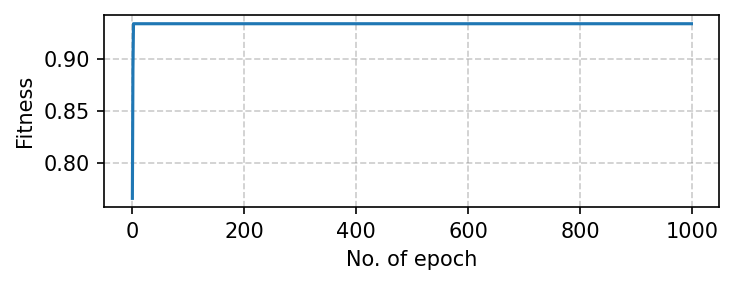

In [15]:
# Visualisation of the learning process 
fig, ax = plt.subplots(figsize=(5, 2), dpi=150, tight_layout=True)
fitness_plot(stoch, ax=ax)
plt.show()

### Stochastic Identification of Weights (SITW)

The third SITW method related to the re-identification of decision models. For this method, re-identification is related to the search for criterion weights. This approach uses the MCDA/MCDM base model combined with a stochastic optimization method to search for weights.

In this example:
- explicit data are: alternatives, rank of alternatives, types of criteria
- implicit data are: criteria weights

In [16]:
# Selection of a stochastic optimization method with its hyperparameters.
stoch = OriginalPSO(epoch=1000, pop_size=100)

# Creation of a SITW model object
sitw = SITW(stoch.solve, SPOTIS(bounds, esp), types)

In [17]:
# Learning the model. The log_to argument was used to avoid search messages per criteria weights epoch.
sitw.fit(matrix, rank_unknown_model, log_to=None)

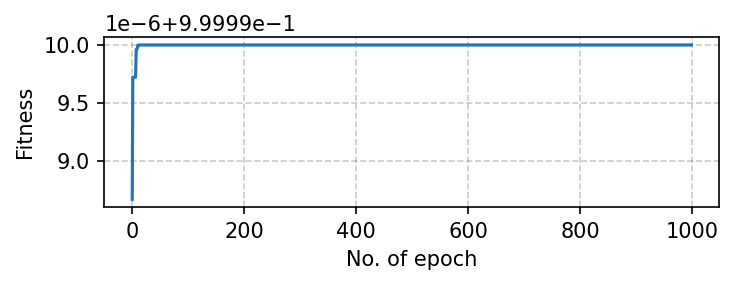

In [18]:
# Visualisation of the learning process 
fig, ax = plt.subplots(figsize=(5, 2), dpi=150, tight_layout=True)
fitness_plot(stoch, ax=ax)
plt.show()

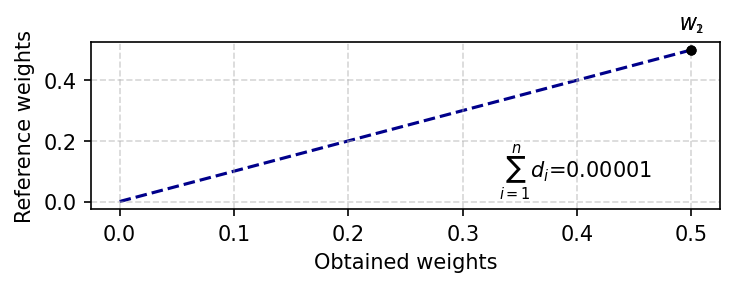

In [19]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=150, tight_layout=True)
weights_diff_plot(weights, sitw(), ax=ax)
plt.show()

In [20]:
# Reference weights
weights

array([0.5, 0.5])

In [21]:
# Obtained weights
sitw()

array([0.49999743, 0.50000257])

In [22]:
# Mean absolute error
print(np.sum(np.abs(weights - sitw())))

5.1400262952583375e-06


### Stochastic Identification of Weights based Local weights (SITWLocal)

The fourth method related to re-identification is the SITWLocal method. In this method, reidentification is based on the determined local weights using the COMET method, unlike the other methods, which are based on ranking-based reidentification. The SITWLocal method is used to determine global weights.

In this example:
- explicit data are: alternatives, local weights of alternatives, types of criteria
- implicit data are: criteria weights

In [23]:
# Unknown COMET expert model
model_comet = COMET(COMET.make_cvalues(matrix, 3), MethodExpert(TOPSIS(), weights, types))

In [24]:
# Local weights from an unknown expert model
local_weights = np.array([get_local_weights(model_comet, alt, percent_step=0.01) for alt in matrix])

In [25]:
# Selection of a stochastic optimization method with its hyperparameters.
stoch = OriginalPSO(epoch=200, pop_size=20)

# Creation of a SITWLocal model object
sitw_local = SITWLocal(stoch.solve, TOPSIS(), types)

In [26]:
# Learning the model. The log_to argument was used to avoid search messages per criteria weights epoch.
sitw_local.fit(matrix, local_weights, log_to=None)

In [27]:
sitw_local()

array([0.3984054, 0.6015946])

### Stochastic Triangular Fuzzy Normalization (STFN)

The fifth approach to re-identifying decision models, using fuzzy normalization, involves re-identifying the cores for the triangular numbers used to normalize the decision matrix, i.e., for individual criteria. A stochastic optimization method is used to select appropriate cores for TFNs.

In [28]:
# Selection of a stochastic optimization method with its hyperparameters.
toch = OriginalPSO(epoch=1000, pop_size=100)

# Creation of a STFN model object
stfn = STFN(stoch.solve, TOPSIS(), bounds, weights)

In [29]:
# Learning the model. The log_to argument was used to avoid search messages per cores epoch.
stfn.fit(matrix, rank_unknown_model, log_to=None)

In [30]:
# Identified cores values
stfn.cores

array([0.50065415, 0.50072847])

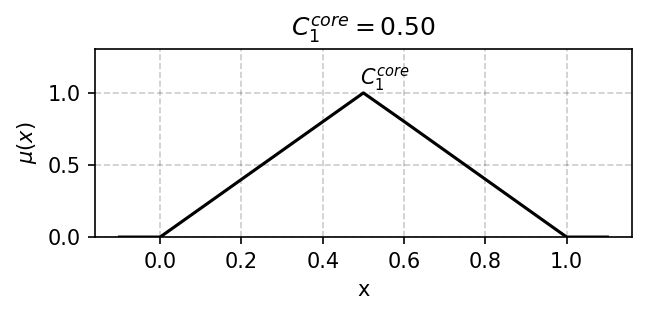

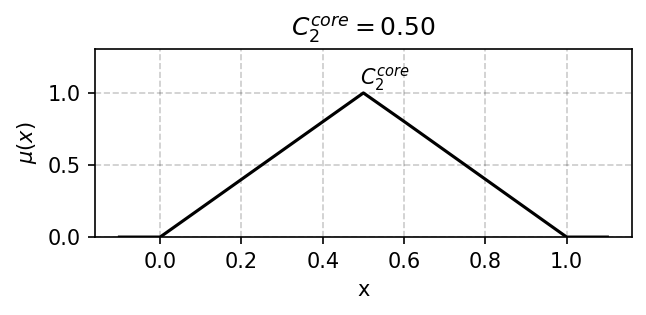

In [31]:
# Plotting the identified triangular fuzzy numbers together with the values of the cores used for normalization
for i, (fun, a, m, b) in enumerate(zip(stfn(), stfn.lb, stfn.cores, stfn.ub), 1):
    fig, ax = plt.subplots(figsize=(4.5, 2.2), dpi=150, tight_layout=True)
    tfn_plot(fun, a, m, b, crit=i, ax=ax)
    plt.show()

In [32]:
# Creating a TOPSIS model with identified triangular numbers for normalization
topsis_fn = TOPSIS(FuzzyNormalization(stfn()))

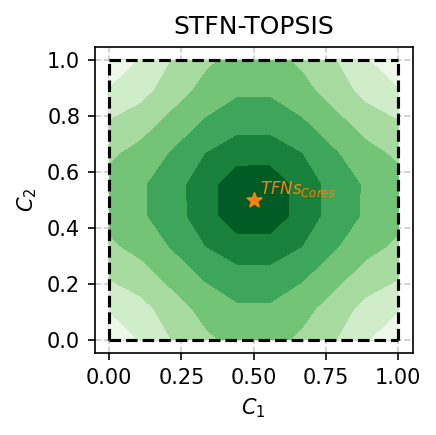

In [33]:
# Exemplary view of the STFN-TOPSIS model
fig, ax = plt.subplots(figsize=(3, 3),  dpi=150, tight_layout=True)
model_contourf(topsis_fn, bounds, esp=stfn.cores, model_kwargs={'weights': weights, 'types': types}, text_kwargs={'text': '$TFNs_{Cores}$'})
ax.set_title('STFN-TOPSIS')
plt.show()

### Stochastic Trapezoidal Fuzzy Normalization (STRFN)

The sixth approach to re-identifying decision models, using fuzzy normalization, involves re-identifying the cores for the trapezoidal numbers used to normalize the decision matrix, i.e. for individual criteria. A stochastic optimization method is used to select appropriate cores for TRFN.

In [34]:
# Selection of a stochastic optimization method with its hyperparameters.
stoch = OriginalPSO(epoch=1000, pop_size=100)

# Creation of a STRFN model object
strfn = STRFN(stoch.solve, TOPSIS(), bounds, weights)

In [35]:
# Learning the model. The log_to argument was used to avoid search messages per cores epoch.
strfn.fit(matrix, rank_unknown_model, log_to=None)

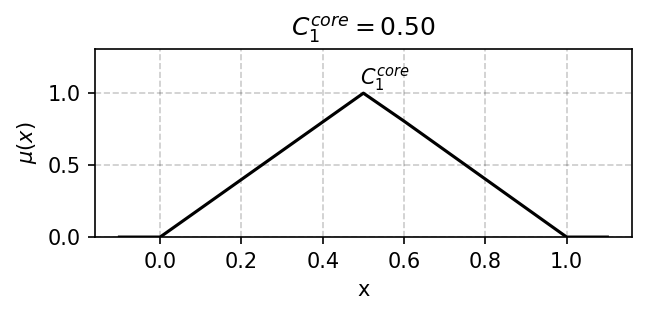

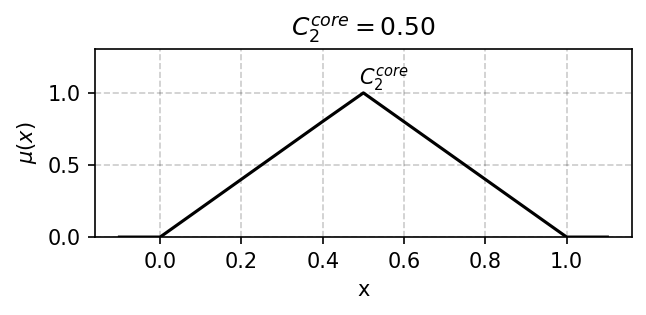

In [36]:
# Plotting the identified trapezoidal fuzzy numbers together with the values of the cores used for normalization
for i, (fun, a, b, c, d) in enumerate(zip(strfn(), strfn.lb[::2], strfn.cores[::2], strfn.cores[1::2], strfn.ub[1::2]), 1):
    fig, ax = plt.subplots(figsize=(4.5, 2.2), dpi=150, tight_layout=True)
    trfn_plot(fun, a, b, c, d, crit=i, ax=ax)
    plt.show()